In [5]:
import cv2
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image

def compute_88blocks():
    global selected_masks
    if not selected_masks:
        return 0
    
    # 创建一个新的图像，大小为(height, width)
    combined_mask = np.zeros_like(selected_masks[0])

    # 将所有的mask叠加到一起
    for mask in selected_masks:
        combined_mask += mask
    
    
    gt_image = to_tensor(combined_mask).squeeze()#to_tensor(Image.fromarray(combined_mask).convert('L')).squeeze()

    if gt_image.size(0) % 8 != 0:
        h = gt_image.size(0) // 8 * 8
        gt_image = gt_image[:h]

    # Do the same for columns
    if gt_image.size(1) % 8 != 0:
        w = gt_image.size(1) // 8 * 8
        gt_image = gt_image[:,:w]


    mask_blocks = ((gt_image)).squeeze().unfold(0, 8, 8).unfold(1, 8, 8).reshape(-1, 8,8)
    #num_valid_blocks = np.sum(np.any(mask_blocks,axis = (1,2)))
    num_valid_blocks = np.sum(np.count_nonzero(mask_blocks, axis=(1, 2)) > 0)
    return num_valid_blocks

In [6]:
import cv2
import numpy as np
from skimage.segmentation import slic

# 定义全局变量
selected_masks = []
segments = None
image = None
superpixel_visualization = None
n_segments = 50  # 初始超像素数量
compactness = 10  # 初始超像素紧密度

# 定义鼠标事件回调函数
def mouse_callback(event, x, y, flags, param):
    global selected_masks, segments, superpixel_visualization,combined_mask
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # 获取当前鼠标位置的超像素ID
        segment_id = segments[y, x]

        # 检查当前选择的超像素是否已经在已选择的mask中
        existing_mask_index = -1
        for i, mask in enumerate(selected_masks):
            if mask[segments == segment_id].any():
                existing_mask_index = i
                break

        if existing_mask_index >= 0:
            # 如果当前选择的超像素已经在已选择的mask中，取消选择
            selected_masks.pop(existing_mask_index)
        else:
            # 创建一个与超像素分割相同形状的空白掩码
            mask = np.zeros_like(segments, dtype=np.uint8)

            # 将选定的超像素的值设置为255，其余值保持为0
            mask[segments == segment_id] = 255

            # 将当前选择的mask保存到列表中
            selected_masks.append(mask)

        # 更新可视化结果
        update_visualization()


# 定义函数，用于更新可视化结果
def update_visualization():
    global selected_masks, segments, image, superpixel_visualization, compactness
    
    # 使用新的超像素数量和紧密度进行SLIC算法分割
    segments = slic(image, n_segments=n_segments, compactness=compactness)
    

    # 创建一个与图像相同形状的临时图像
    superpixel_visualization = image.copy()
    
    # 绘制超像素边界
    for segment_id in np.unique(segments):
        segment_mask = np.zeros_like(segments, dtype=np.uint8)
        segment_mask[segments == segment_id] = 255
        contours, _ = cv2.findContours(segment_mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.findContours(segment_mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)#cv2.findContours(segment_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(superpixel_visualization, contours, -1, (255, 0, 0), 2)

    # 叠加已选择的mask到可视化结果上
    for mask in selected_masks:
        superpixel_visualization[mask != 0] = [0, 255, 0]  # 将mask区域设置为绿色


    # 在窗口中显示可视化结果
    cv2.putText(superpixel_visualization, f'num of 8*8 blocks: {compute_88blocks()}',(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.imshow('Superpixel Segmentation', superpixel_visualization)
    

    

# 定义回调函数，用于更新超像素数量和紧密度
def update_parameters(value):
    global n_segments, compactness, selected_masks
    n_segments = cv2.getTrackbarPos('n_segments', 'Controls')
    compactness = cv2.getTrackbarPos('compactness', 'Controls')
    selected_masks = []  # 清空已选择的mask
    update_visualization()
    

# 读取图像
image = cv2.imread('comp30.jpg')

# 使用SLIC算法进行超像素分割
segments = slic(image, n_segments=n_segments, compactness=compactness)

# 创建窗口并注册鼠标回调函数
cv2.namedWindow('Superpixel Segmentation')
cv2.setMouseCallback('Superpixel Segmentation', mouse_callback)

# 创建控制参数的窗口
cv2.namedWindow('Controls')
cv2.createTrackbar('n_segments', 'Controls', n_segments, 200, update_parameters)
cv2.createTrackbar('compactness', 'Controls', compactness, 20, update_parameters)
# 显示当前的n_segments和compactness参数
# 显示当前的n_segments和compactness参数值
#cv2.putText('Controls', f'n_segments: {n_segments}')


# 初始化可视化结果
update_visualization()

# 进入主循环，等待用户操作
while True:
    key = cv2.waitKey(1)

    # 按下ESC键退出循环
    if key == 27:
        break
        
    
    cv2.imshow('Superpixel Segmentation', superpixel_visualization)

# 清理资源
cv2.destroyAllWindows()


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:866: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


In [49]:
pixels_blocks

tensor([[[127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         ...,
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.]],

        [[127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         ...,
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.]],

        [[127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         ...,
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.],
         [127., 127., 127.,  ..., 127., 127., 127.]],

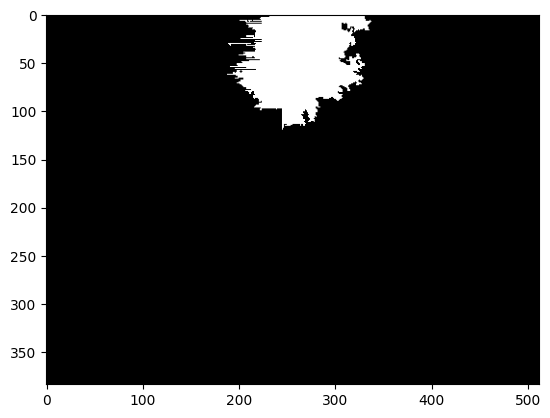

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有一个包含多个mask的列表selected_masks
# 假设每个mask对应于相同的图像，形状为(height, width)

# 创建一个新的图像，大小为(height, width)
combined_mask = np.zeros_like(selected_masks[0])

# 将所有的mask叠加到一起
for mask in selected_masks:
    combined_mask += mask

    

    

# 显示图像
plt.imshow(combined_mask, cmap='gray')

plt.show()


In [60]:
from PIL import Image

# 将combined_mask转换为PIL图像对象
combined_image = Image.fromarray(combined_mask)#.astype(np.uint8) * 255)

# 保存为PNG图像文件
combined_image.save("combined_mask.png")


In [61]:

# 将image转换为PIL图像对象
#comp_image = Image.fromarray(image)#.astype(np.uint8) * 255)
comp_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# 保存为jpg图像文件
comp_image.save("comp_image.jpg")

#comp_image